## Import

In [14]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import os
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nmt.model import EncoderLSTM, DecoderLSTM, DotAttenDecoderLSTM
from nmt.train import train, trainIters
from nmt.infer import infer
from nmt.eval import eval
from nmt.utils import BatchGenerator

## Data Setup

In [3]:
MAX_LENGTH = 25

In [4]:
# set data path
data_dir = os.path.join('datasets', 'nmt_data_vi')
train_source = 'train.vi'
train_target = 'train.en'
train_source_dir = os.path.join(data_dir, train_source)
train_target_dir = os.path.join(data_dir, train_target)

test_source = 'tst2012.vi'
test_target = 'tst2012.en'
test_source_dir = os.path.join(data_dir, test_source)
test_target_dir = os.path.join(data_dir, test_target)

vocab_source = 'vocab.vi'
vocab_target = 'vocab.en'
vocab_source_dir = os.path.join(data_dir, vocab_source)
vocab_target_dir = os.path.join(data_dir, vocab_target)

In [5]:
# load training sets
with open(train_source_dir) as f_source:
    sentences_source = f_source.readlines()
with open(train_target_dir) as f_target:
    sentences_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source training set: {}".format(len(sentences_source)))
print("Total number of sentences in target training set: {}".format(len(sentences_target)))

# load testing sets
with open(test_source_dir) as f_source:
    test_source = f_source.readlines()
with open(test_target_dir) as f_target:
    test_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source testing set: {}".format(len(test_source)))
print("Total number of sentences in target testing set: {}".format(len(test_target)))

Total number of sentences in source training set: 133317
Total number of sentences in target training set: 133317
Total number of sentences in source testing set: 1553
Total number of sentences in target testing set: 1553


In [6]:
# check the longest sentence after sentence truncation
max = 0
for s in sentences_source:
    if len(s) > max:
        max = len(s)
        max_s = s
print("Number of words in the longest sentence in sentences_source: {}".format(max))
print("The longest sentence: \n{}".format(max_s))

Number of words in the longest sentence in sentences_source: 3199
The longest sentence: 
Thula Mama , Thula Mama , Thula Mama , Thula Mama . Trong kí ức tuổi thơ con , qua những giọt lệ nhoè mắt bà , con thấy chân lý trong nụ cười của bà , con thấy chân lý trong nụ cười của bà , xuyên thấu màn đêm u tối trong sự vô tri của con . Ôi , có một người bà đang nằm nghỉ bà ốm đau và trái tim bà rơi lệ . Băn khoăn , băn khoăn , băn khoăn , băn khoăn liệu thế giới này đang đi về đâu . Lẽ nào chuyện trẻ nhỏ phải tự xoay xở lấy là đúng ? Không , không , không , không , không , không . Lẽ nào phiền muộn dồn hết lên mái đầu người phụ nữ già là đúng ? Những người vô danh bất hạnh . Thula Mama Mama , Thula Mama . Thula Mama Mama . Thula Mama , Thula Mama , Thula Mama Mama , Thula Mama . Ngày mai sẽ tốt đẹp hơn . Ngày mai trèo đèo lội suối sẽ dễ hơn , bà ơi . Thula Mama , Thula Mama . Tôi có nên tan vào bài hát này như người đàn ông hát nhạc blues hay một người hát rong . Và rồi từ rất xa , không phải

In [7]:
# Truncate sentences by maximum length
sentences_source = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_source))
sentences_target = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_target))
test_source = list(map(lambda src:src.split()[:MAX_LENGTH], test_source))
test_target = list(map(lambda src:src.split()[:MAX_LENGTH], test_target))

In [8]:
# Delete empty sentences in source and target
i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del sentences_source[i]
        del sentences_target[i]
        i -= 1
    i += 1
print(len(sentences_source))
print(len(sentences_target))

i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del test_source[i]
        del test_target[i]
        i -= 1
    i += 1
print(len(test_source))
print(len(test_target))

133166
133166
1553
1553


In [9]:
# load vocabularies

# build index2word
with open(vocab_source_dir) as f_vocab_source:
    #index2word_source = f_vocab_source.readlines()
    index2word_source = [line.rstrip() for line in f_vocab_source]
with open(vocab_target_dir) as f_vocab_target:
    #index2word_target = f_vocab_target.readlines()
    index2word_target = [line.rstrip() for line in f_vocab_target]

# build word2index
word2index_source = {}
for idx, word in enumerate(index2word_source):
    word2index_source[word] = idx
word2index_target = {}
for idx, word in enumerate(index2word_target):
    word2index_target[word] = idx
    
# check vocabularies size    
source_vocab_size = len(index2word_source)
target_vocab_size = len(index2word_target)
print("Total nummber of words in source vocabulary: {}".format(len(index2word_source)))
print("Total nummber of words in target vocabulary: {}".format(len(index2word_target)))    

Total nummber of words in source vocabulary: 7709
Total nummber of words in target vocabulary: 17191


## Parameters Setup

In [10]:
# misc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# encoder & decoder init
input_size = source_vocab_size
output_size = target_vocab_size+1 # +1 is a wordaround for ignore_index field of NLLLoss
hidden_size = 512
dropout = 0.2
attention_vector_size = 256

# train & test & infer
PAD_token = target_vocab_size # this padding token is ignored for loss calculation
SOS_token = 1
EOS_token = 2
batch_size = 128

## Training

In [11]:
batch_generator_train = BatchGenerator(batch_size, sentences_source, sentences_target, word2index_source, word2index_target, EOS_token, device)
batch_generator_test = BatchGenerator(batch_size, test_source, test_target, word2index_source, word2index_target, EOS_token, device)

encoder1 = EncoderLSTM(input_size, hidden_size, dropout=dropout).to(device)
decoder1 = DotAttenDecoderLSTM(hidden_size, output_size, attention_vector_size, dropout=dropout).to(device) 

bleu_params = {}
bleu_params['sentences_source'] = test_source
bleu_params['sentences_ref'] = test_target
bleu_params['max_length'] = MAX_LENGTH
bleu_params['word2index_source'] = word2index_source
bleu_params['word2index_target'] = word2index_target
bleu_params['index2word_target'] = index2word_target
bleu_params['EOS_token'] = EOS_token

plot_losses_train, plot_losses_test, plot_bleu = trainIters(batch_generator_train, batch_generator_test, encoder1, decoder1, 6000, batch_size, device, SOS_token, PAD_token, print_every=100, step_every_epoch = 1000, learning_rate=0.001, bleu_params=bleu_params)

(step:100 1%) loss_train:6.3678, loss_test:5.7153
(step:200 3%) loss_train:5.6977, loss_test:5.3062
(step:300 5%) loss_train:5.3676, loss_test:5.1078
(step:400 6%) loss_train:5.1668, loss_test:4.9997
(step:500 8%) loss_train:5.0503, loss_test:4.8795
(step:600 10%) loss_train:4.9410, loss_test:4.6733
(step:700 11%) loss_train:4.8602, loss_test:4.6640
(step:800 13%) loss_train:4.7707, loss_test:4.5047
(step:900 15%) loss_train:4.6957, loss_test:4.3347
(step:1000 16%) loss_train:4.6259, loss_test:4.5507
epoch: 1
bleu_test:0.029368046047591533
(step:1100 18%) loss_train:4.5331, loss_test:4.3256
(step:1200 20%) loss_train:4.4285, loss_test:4.3394
(step:1300 21%) loss_train:4.3844, loss_test:4.2747
(step:1400 23%) loss_train:4.3431, loss_test:4.2261
(step:1500 25%) loss_train:4.2857, loss_test:4.2034
(step:1600 26%) loss_train:4.2365, loss_test:3.8824
(step:1700 28%) loss_train:4.1793, loss_test:4.1155
(step:1800 30%) loss_train:4.1609, loss_test:3.8881
(step:1900 31%) loss_train:4.1127, los

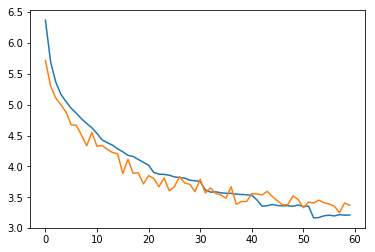

In [18]:
plt.plot(plot_losses_train)
plt.plot(plot_losses_test)
plt.show()

In [23]:
torch.mean(torch.abs(encoder1.lstm.weight_hh_l0))

tensor(1.00000e-02 *
       8.2240, device='cuda:0')